In [1]:
from keypoint_moseq.io import setup_project, load_config, format_data, save_pca
from keypoint_moseq.visualize import plot_scree, plot_pcs
from keypoint_moseq.initialize import fit_pca
from keypoint_moseq.util import to_jax

### Setup project

In [2]:
project_directory = 'test'
dlc_config = 'data/dlc_config.yml'

config_options = {
    'use_bodyparts': ['spine4','spine3','spine2','spine1','head','nose','right ear','left ear'],
    'anterior_bodyparts': ['head'],
    'posterior_bodyparts': ['spine4']}

setup_project(project_directory, deeplabcut_config=dlc_config, **config_options)
config = load_config(project_directory)

### Load data

In [3]:
import pickle
keypoints = pickle.load(open('data/keypoints.p','rb'))
coordinates = {k:v[...,:2] for k,v in keypoints.items()}
confidence = {k:v[...,2] for k,v in keypoints.items()}
data = to_jax(format_data(coordinates, confidence=confidence, **config))

### Fit PCA

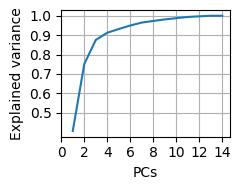

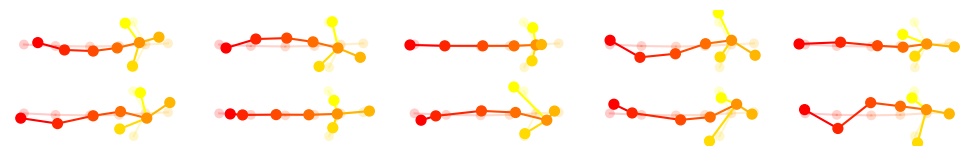

In [4]:
pca = fit_pca(**data, **config)
save_pca(pca, project_directory)

plot_scree(pca, project_directory=project_directory)
plot_pcs(pca, project_directory=project_directory, **config)

### Initialize

In [ ]:
key = jr.PRNGKey(0)
data = {'mask':mask, 'Y':Y}
states = {}
params = {}

states['v'] = initial_location(**data)
states['h'] = initial_heading(posterior_keypoints, anterior_keypoints, **data)
states['x'],params['Cd'], pca_model = initial_latents(latent_dim=latent_dim, **data, **states)

params['betas'],params['pi'] = initial_hdp_transitions(key, **trans_hypparams)
params['Ab'],params['Q']= initial_ar_params(key, **ar_hypparams)
params['sigmasq'] = jnp.ones(Y.shape[-2])

states['z'],_ = resample_stateseqs(key, **data, **states, **params)
states['s'] = resample_scales(key, **data, **states, **params, **obs_hypparams)


### Gibbs sampling (AR-only)

In [ ]:
num_iters = 500
plot_iters = 10
keys = jr.split(key,num_iters)

for i in tqdm.trange(num_iters):
    params['betas'],params['pi'] = resample_hdp_transitions(keys[i], **data, **states, **params, **trans_hypparams)
    params['Ab'],params['Q']= resample_ar_params(keys[i], **data, **states, **params, **ar_hypparams)
    states['z'],_ = resample_stateseqs(keys[i], **data, **states, **params)
    
    if i % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((12,3))
        plt.show()

### Gibbs sampling (full model)

In [ ]:
trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 100, 
    'kappa': 1e6/50,
    'num_states':num_states}

In [ ]:
num_iters = 500
plot_iters = 10
keys = jr.split(key,num_iters)

for i in tqdm.trange(num_iters):
    params['Ab'],params['Q'] = resample_ar_params(keys[i], **data, **states, **params, **ar_hypparams)
    params['sigmasq'] = resample_obs_variance(keys[i], **data, **states, **params, **obs_hypparams)
    params['betas'],params['pi'] = resample_hdp_transitions(keys[i], **data, **states, **params, **trans_hypparams)    
    states['z'] = resample_stateseqs(keys[i], **data, **states, **params)[0]
    states['x'] = resample_latents(keys[i], **data, **states, **params)
    states['h'] = resample_heading(keys[i], **data, **states, **params)
    states['v'] = resample_location(key, **data, **states, **params, **translation_hypparams)
    states['s'] = resample_scales(keys[i], **data, **states, **params, **obs_hypparams)
    
    if i % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((8,2))
        plt.suptitle('Iteration {}, Median duration = {}'.format(i, np.median(durations)))
        plt.show()